# Figure 1c: Feature Visualization (GR, LEW, TED)

Figure 1a-d illustrate key steps in the NaRRS snow depth and SIT processing chain and are combined with a flow chart to create Figure 1 in the manuscript. 

Here we will plot the three features used in our final snow depth retrieval model over a section of a coincident OLCI true color composite. The GR is plotted to scale of the 23.5 km diameter bins that the LEW, TED, and freeboard, are subsequently averaged within for snow depth and SIT retrieval.

**Data required**
* The pysiral-processed S3 SRAL data and water (atmopsheric and surface) corrected MWR data. The orginial S3 L2 Sea Ice Thematic data used in this example comes from product S3A_SR_2_LAN_SI_20190409T220052_20190409T221734_20230529T124528_1001_043_229______LN3_R_NT_005.SEN3. The processed datasets can be found in NaRRS/Data/pysiral-l1p-sentinel3a-l2_lan_si-rep-north-20190409T220134-20190409T221733-waveform_features.nc for the processed SRAL data and S3A_SR_2_LAN_SI_20190409T220052_20190409T221734_20230529T124528_1001_043_229______LN3_R_NT_005.SEN3/NaRRS_Sentinel3_snow_depth_and_sea_ice_thickness.nc for the corrected MWR data.
* Coincident OLCI data, located at NaRRS/Data/S3A_OL_1_EFR____20190409T220940_20190409T221240_20240531T201722_0179_043_229_1620_MAR_R_NT_004.SEN3 / downloadable from the Copernicus Data Space Ecosystem https://dataspace.copernicus.eu/. 

**Software required**

In addition to the satpy Python package (https://satpy.readthedocs.io/en/stable/), we use a custom 'highlight_optimised_true_color' composite defined in the script NaRRS/Misc/satpy_customs/composites/highlight_optimised_true_color.py.


1) Import required packages

In [1]:
import sys
sys.path.append('/home/cn/NaRRS')
sys.path.append('../Misc/satpy_customs/composites')
import satpy
satpy.config.set(config_path=['../Misc/satpy_customs/'])
import os
import numpy as np
import xarray as xr
import pyproj
from cftime import num2pydate
from glob import glob
from pathlib import Path
from satpy import Scene
from satpy.writers import get_enhanced_image
from satpy.composites import SelfSharpenedRGB
from shapely.geometry import Polygon, Point
from shapely.ops import transform
import matplotlib.pyplot as plt
from matplotlib import gridspec
from joblib import Parallel, delayed

2) Define functions to find and process relevant files

In [2]:
def load_waveform_features_ds(waveform_fpaths, hemisphere, si_only=True):
    
    """
    Function to read the pysrial-processed Sentinel-3 L2 Sea Ice Thematic Dataset""
    
    Parameters:
    waveform_fpaths (list of str): List of file paths to the NetCDF4 files containing the pysiral (L1P) files.
    hemisphere (str): Hemisphere indicator, either 'nh' for Northern Hemisphere or 'sh' for Southern Hemisphere.
    si_only (bool, optional): If True, filter the dataset to include only sea ice surface types. Default is True.
    
    Returns:
    xr.Dataset: Merged xarray Dataset containing classifier, time_orbit, and waveform data with appropriate renaming and coordinate assignment.
    """
    
    waveforms_ds = []
    for fpath in waveform_fpaths:
        classifer_ds = xr.open_dataset(fpath, group ='classifier', drop_variables=['brightness_temperature_238', 'brightness_temperature_365'])
        orbit_ds = xr.open_dataset(fpath, group ='time_orbit', drop_variables=['altitude', 'altitude_rate', 'antenna_pitch', 'antenna_roll', 'antenna_yaw', 'antenna_mispointing', 'orbit_flag'])
        ds = xr.merge([classifer_ds, orbit_ds], join='inner')
        ds =  ds.rename_dims({'n_records': 'time_20_ku'})
        ds = ds.assign_coords({'time_20_ku':num2pydate(ds['timestamp'].values, units="seconds since 1970-01-01 00:00:00.0")})
        ds = ds.rename_vars({'latitude': 'lat_20_ku', 'longitude': 'lon_20_ku'})

        def convert_lon_easting_format(longitude):
            if longitude >180 and longitude <= 360:
                longitude = longitude - 360
            return longitude
        
        def get_ease2_epsg(hemisphere):
            if hemisphere == 'nh':
                return 6931
            if hemisphere == 'sh':
                return 6932
            raise ValueError("Hemisphere must be 'nh' or 'sh'")
        
        ds['lon_20_ku'] = (('time_20_ku'),Parallel(n_jobs=20, prefer="threads")(delayed(convert_lon_easting_format)(longitude) for longitude in ds['lon_20_ku'].values))
        proj = pyproj.Transformer.from_crs(4326, get_ease2_epsg(hemisphere), always_xy=True)
        xc, yc = proj.transform(ds['lon_20_ku'].values, ds['lat_20_ku'].values)
        ds = ds.assign_coords({'xc_20_ku':(('time_20_ku'),xc), 'yc_20_ku':(('time_20_ku'),yc)})
        if si_only:
            ds = ds.where(ds['surface_type_classification'] == 1, drop=True)
        waveforms_ds.append(ds)
    waveform_ds = xr.concat(waveforms_ds, dim='time_20_ku')
    waveform_ds = waveform_ds.drop_duplicates('time_20_ku')
    waveform_ds = waveform_ds.sortby('time_20_ku').drop_vars(['timestamp'])
    return  waveform_ds

#==============================================================================================================================================================#

def transform_coords(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2
    
    Parameters:
    proj1 (int): EPSG code of the current projection
    proj2 (int): EPSG code of the target projection
    x (float or array-like): x-coordinate(s) in the current projection
    y (float or array-like): y-coordinate(s) in the current projection
    
    Returns:
    tuple: Transformed x and y coordinates in the target projection
    
    Common projections: 
    WGS 84 (4326)
    EASE2 (NH: 6931, SH:6932)
    Polar Stereographic (NH: 3413, SH:3976)
    EASE (NH:3408, SH:3409)
    """

    proj = pyproj.Transformer.from_crs(proj1, proj2, always_xy=True)

    return proj.transform(x, y)

#========================================================================================================================#

def get_image(scene, datasetID):
    """Generate self-sharpened RGB composite from Satpy Scene object.
    This should help bring out finer features in the image.
    
    Parameters:
    scene (satpy.Scene): Satpy Scene object containing satellite data.
    datasetID (str): Identifier for the dataset within the Scene to be processed.
    Returns:
    xarray.DataArray: Enhanced RGB composite image.
    """
    
    compositor = SelfSharpenedRGB('self_sharpened_composite')
    composite = compositor(scene[datasetID])
    composite.attrs = scene[datasetID].attrs
    return get_enhanced_image(composite)

#========================================================================================================================#

def get_olci_polygon(xcs, ycs):
    """
    Generate a Shapely Polygon representing the boundary of OLCI data coverage.
    
    Parameters:
    xcs (2D array-like): Array of x-coordinates of OLCI data points.
    ycs (2D array-like): Array of y-coordinates of OLCI data points.
    
    Returns:
    shapely.geometry.Polygon: Polygon representing the OLCI data coverage boundary.
    """
    
    x_boundary = np.concatenate([xcs[0,:], xcs[:,-1], np.flip(xcs[-1, :]), np.flip(xcs[:,0])])
    y_boundary = np.concatenate([ycs[0,:], ycs[:,-1], np.flip(ycs[-1, :]), np.flip(ycs[:,0])])
    return Polygon(zip(x_boundary, y_boundary))

#=============================================================================================================================================================#

def is_point_in_olci_polygon(point, olci_polygon):
    """
    Check if a given point is inside the OLCI polygon.
    
    Parameters:
    point (shapely.geometry.Point): The point to check.
    olci_polygon (shapely.geometry.Polygon): A shapely polygon representing OLCI data coverage.
    
    Returns:
    bool: True if the point is inside the polygon, False otherwise.
    """
    
    return olci_polygon.contains(point)

#=============================================================================================================================================================#

def crop_ds_to_olci(ds, olci_polygon, time_dim='time_01'):
    """
    Crop an xarray Dataset to only include data points within the OLCI polygon.
    
    Parameters:
    ds (xarray.Dataset): The dataset to be cropped.
    olci_polygon (shapely.geometry.Polygon): A shapely polygon representing OLCI data coverage.
    time_dim (str): The name of the time dimension in the dataset. It is assumed that the x and y coordinates are named 'xc_<suffix>' and 'yc_<suffix>', where <suffix> is derived from the time dimension name, e.g., 'time_01' -> '01'.
    
    Returns:
    xarray.Dataset: The cropped dataset containing only points within the OLCI polygon.
    """
    
    mwr_data_points = [Point(x, y) for x, y in zip(ds[f'xc_{time_dim.split("time_")[1]}'], ds[f'yc_{time_dim.split("time_")[1]}'])]
    in_olci = Parallel(n_jobs=32, prefer="threads")(delayed(is_point_in_olci_polygon)(point, olci_polygon) for point in mwr_data_points)
    cropped_ds = ds.where(xr.DataArray(in_olci, dims=time_dim), drop=True)
    return cropped_ds

#=============================================================================================================================================================#

def get_circular_geospatial_polygon(xc, yc, r, coord_epsg, return_epsg=None):
    """
    Generate a circular polygon around a given center point.
    
    Parameters:
    xc (float): x-coordinate of the center point.
    yc (float): y-coordinate of the center point.
    r (float): radius of the circular footprint.
    coord_epsg (int): EPSG code of the input coordinates.
    return_epsg (int, optional): EPSG code to transform the polygon to. If None, the polygon is returned in the original coordinate system.
    
    Returns:
    shapely.geometry.Polygon: Circular polygon.
    """
    
    theta = np.linspace(0,2*np.pi, 100)
    theta = np.append(theta,0)
    x_bounds = xc+ r*np.cos(theta)
    y_bounds = yc + r*np.sin(theta)
    polygon = Polygon(list(map(list,zip(x_bounds,y_bounds))))
    
    if return_epsg is None:
        return polygon
    
    transformer = pyproj.Transformer.from_crs(pyproj.CRS(f"EPSG:{coord_epsg}"), pyproj.CRS(f"EPSG:{return_epsg}"), always_xy=True)
    return transform(transformer.transform, polygon)

#==============================================================================================================================================================#

def shift_track_perpendicular(x_coords, y_coords, shift_distance):
    
    """
    Shifts a 2D track (defined by x and y coordinates) perpendicularly.
    This function is designed for data in a projected coordinate system with units of meters (i.e., not lat/lon coordinates).
    It calculates two new tracks, one shifted to the left and one to the right,
    relative to the direction of travel along the original nadir track.

    Parameters:
    x_coords (array-like): Array of x-coordinates of the original track.
    y_coords (array-like): Array of y-coordinates of the original track.
    shift_distance (float): The perpendicular distance (in the same units as the coordinates) to shift the tracks by.

    Returns:
    tuple: Two tuples containing the shifted coordinates:
        - (left_x, left_y): Coordinates of the track shifted to the left.
        - (right_x, right_y): Coordinates of the track shifted to the right.
        
    """
    #calculate the x and y direction vector at each point
    dx = np.gradient(x_coords)
    dy = np.gradient(y_coords)

    #calculate the magnitude of the direction/tangent vector, representing the euclidean distance between points
    magnitude = np.sqrt(dx**2 + dy**2)
    
    #calculate the normal unit vectors
    #left side (rotate 90 degrees counter-clockwise)
    nx1 = -dy / magnitude
    ny1 =  dx / magnitude

    #right side (rotate 90 degrees clockwise)
    nx2 =  dy / magnitude
    ny2 = -dx / magnitude

    #calculate the new coordinates (add the scaled normal vectors to the original coordinates)
    left_x = x_coords + shift_distance * nx1
    left_y = y_coords + shift_distance * ny1
    right_x = x_coords + shift_distance * nx2
    right_y = y_coords + shift_distance * ny2

    return ((left_x, left_y), (right_x, right_y))

3) Define constants

In [3]:
# Constants
EPSG_CODE = 6931

4) Load the Sentinel-3 SRAL/MWR datasets. We will take the GR (corrected for atmopsheric and surface water contamination) from the final NaRRS dataset, and the LEW and TED from the pysiral-processed dataset.

In [4]:
#S3 L2 SI Thematic product name
l2_product_name = 'S3A_SR_2_LAN_SI_20190409T220052_20190409T221734_20230529T124528_1001_043_229______LN3_R_NT_005.SEN3'

#load the processed S3 NaRRS snow depth and SIT product - this will have the corrected GR in it
processed_fpath = Path(f'../Data/{l2_product_name}/NaRRS_Sentinel3_snow_depth_and_sea_ice_thickness.nc')
processed_ds = xr.open_dataset(processed_fpath)

#load the pysiral-processed waveform feature dataset containing LEW and TED
waveform_features_fpaths = [f'../Data/pysiral-l1p-sentinel3a-l2_lan_si-rep-north-20190409T220134-20190409T221733-waveform_features.nc']
waveform_features_ds = load_waveform_features_ds(waveform_features_fpaths, hemisphere='nh', si_only=True)

#apply the same quality filters as used in the main analysis/described in the manuscript
waveform_features_ds= waveform_features_ds.where(
        (waveform_features_ds['trailing_edge_width'] > 1) &
        (waveform_features_ds['trailing_edge_decay_fit_quality'] > 0.8) &
        (waveform_features_ds['first_maximum_power'] == 1),
        drop=True
    )

5) Define a bounding box to crop the datasets to, reducing the memory load

In [5]:
#define a bounding box
bbox = [-155.8, -136.2, 74.02, 77.9]
#make a polygon of the bbox
bbox_polygon = Polygon([(bbox[0], bbox[2]), (bbox[1], bbox[2]), (bbox[1], bbox[3]), (bbox[0], bbox[3]), (bbox[0], bbox[2])])

6) Load the OLCI data, create a composite image and crop to the bounding box

In [6]:
#OLCI
#load OLCI data
olci_fpath = '../Data/S3A_OL_1_EFR____20190409T220940_20190409T221240_20240531T201722_0179_043_229_1620_MAR_R_NT_004.SEN3'
scn = Scene(reader='olci_l1b', filenames=glob(olci_fpath+'/*'))

#create a composite image of the OLCI data
# composite = 'true_color'
composite = 'highlight_optimised_true_color'
scn.load([composite])
lons, lats = scn[composite].attrs['area'].get_lonlats()
xcs, ycs = transform_coords(4326, EPSG_CODE, lons, lats)
img = get_image(scn, composite)
img_rgb = img.data.transpose('y','x','bands')
img_rgb = img_rgb.clip(0,1)

#add the lons and lats to the image
img_rgb['xcs'] = (('y', 'x'), xcs)
img_rgb['ycs'] = (('y', 'x'), ycs)
img_rgb['lons'] = (('y', 'x'), lons)
img_rgb['lats'] = (('y', 'x'), lats)

#crop the image to the bounding box
img_rgb = img_rgb.compute()
img_rgb = img_rgb.where((img_rgb['lons'] >= bbox[0]) & (img_rgb['lons'] <= bbox[1]) &
                        (img_rgb['lats'] >= bbox[2]) & (img_rgb['lats'] <= bbox[3]), drop=True)

#make a polygon of the remaining OLCI coverage
olci_polygon = get_olci_polygon(img_rgb['xcs'], img_rgb['ycs'])

/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'bands'} appear more than once in dims=('bands', 'bands'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/cn/.conda/envs/pysiralp/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Don't know how to open the following files: {'../Data/S3A_OL_1_EFR____20190409T220940_20190409T221240_20240531T201722_0179_043_2

6) Crop the SRAL/MWR datasets to the region bound by the cropped OLCI image

In [7]:
#crop the S3 datasets to the OLCI polygon
processed_ds = crop_ds_to_olci(processed_ds, olci_polygon, time_dim='time_01')
waveform_features_ds = crop_ds_to_olci(waveform_features_ds, olci_polygon, time_dim='time_20_ku')

7) Create polygons representing each measurement, for the GR these will show the approximate footprint of the 23.8 GHz channel and will also represent the bins used for along-track binning of LEW and TED in this study. The LEW/TED coordinates will be shifted slightly left/right from nadir, allowing us to see both clearly.

In [8]:
#get MWR GR polygons
r = 23.5e3/2
mwr_polygons = []
for xc, yc in zip(processed_ds['xc_01'].values, processed_ds['yc_01'].values):
    mwr_polygons.append(get_circular_geospatial_polygon(xc, yc, r, coord_epsg=EPSG_CODE, return_epsg=4326))

#create the colormap for GR
gr_vmin=-0.0250
gr_vmax=0.0
norm = plt.Normalize(vmin=gr_vmin, vmax=gr_vmax)
s3_gr_colors = plt.cm.Reds_r(norm(processed_ds['gradient_ratio_corrected_01'].values))
gr_sm = plt.cm.ScalarMappable(cmap='Reds_r', norm=norm)

#shift the waveform feature coords to the left and right of track so we can later visualise them side by side
shift_distance = 1.8e3 #1.8 km shift
shifted_sral_coords = shift_track_perpendicular(waveform_features_ds['xc_20_ku'].values, waveform_features_ds['yc_20_ku'].values, shift_distance)
shifted_lew_xcs, shifted_lew_ycs = shifted_sral_coords[0]
shifted_ted_xcs, shifted_ted_ycs = shifted_sral_coords[1]

#get SRAL LEW polygons
sral_lew_r = 1.5e3
sral_lew_polygons = []
for xc, yc in zip(shifted_lew_xcs, shifted_lew_ycs):
    sral_lew_polygons.append(get_circular_geospatial_polygon(xc, yc, sral_lew_r, coord_epsg=EPSG_CODE, return_epsg=4326))

#create the colormap for LEW
lew_vmin=1
lew_vmax=3 
norm = plt.Normalize(vmin=lew_vmin, vmax=lew_vmax)
lew_colors = plt.cm.viridis(norm(waveform_features_ds['leading_edge_width'].values))
lew_sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)

#get SRAL TED polygons
sral_ted_r = 1.6e3
sral_ted_polygons = []
for xc, yc in zip(shifted_ted_xcs, shifted_ted_ycs):
    sral_ted_polygons.append(get_circular_geospatial_polygon(xc, yc, sral_ted_r, coord_epsg=EPSG_CODE, return_epsg=4326))
    
#create the colormap for TED
ted_vmin=0
ted_vmax=1
norm = plt.Normalize(vmin=ted_vmin, vmax=ted_vmax)
ted_colors = plt.cm.plasma(norm(waveform_features_ds['trailing_edge_decay'].values))
ted_sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)


8) Plot the GR, LEW, and TED polygons over the OLCI composite image. We will focus on a zoomed-in region for a clearer and more compact figure.

/tmp/ipykernel_2981244/2288520363.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(


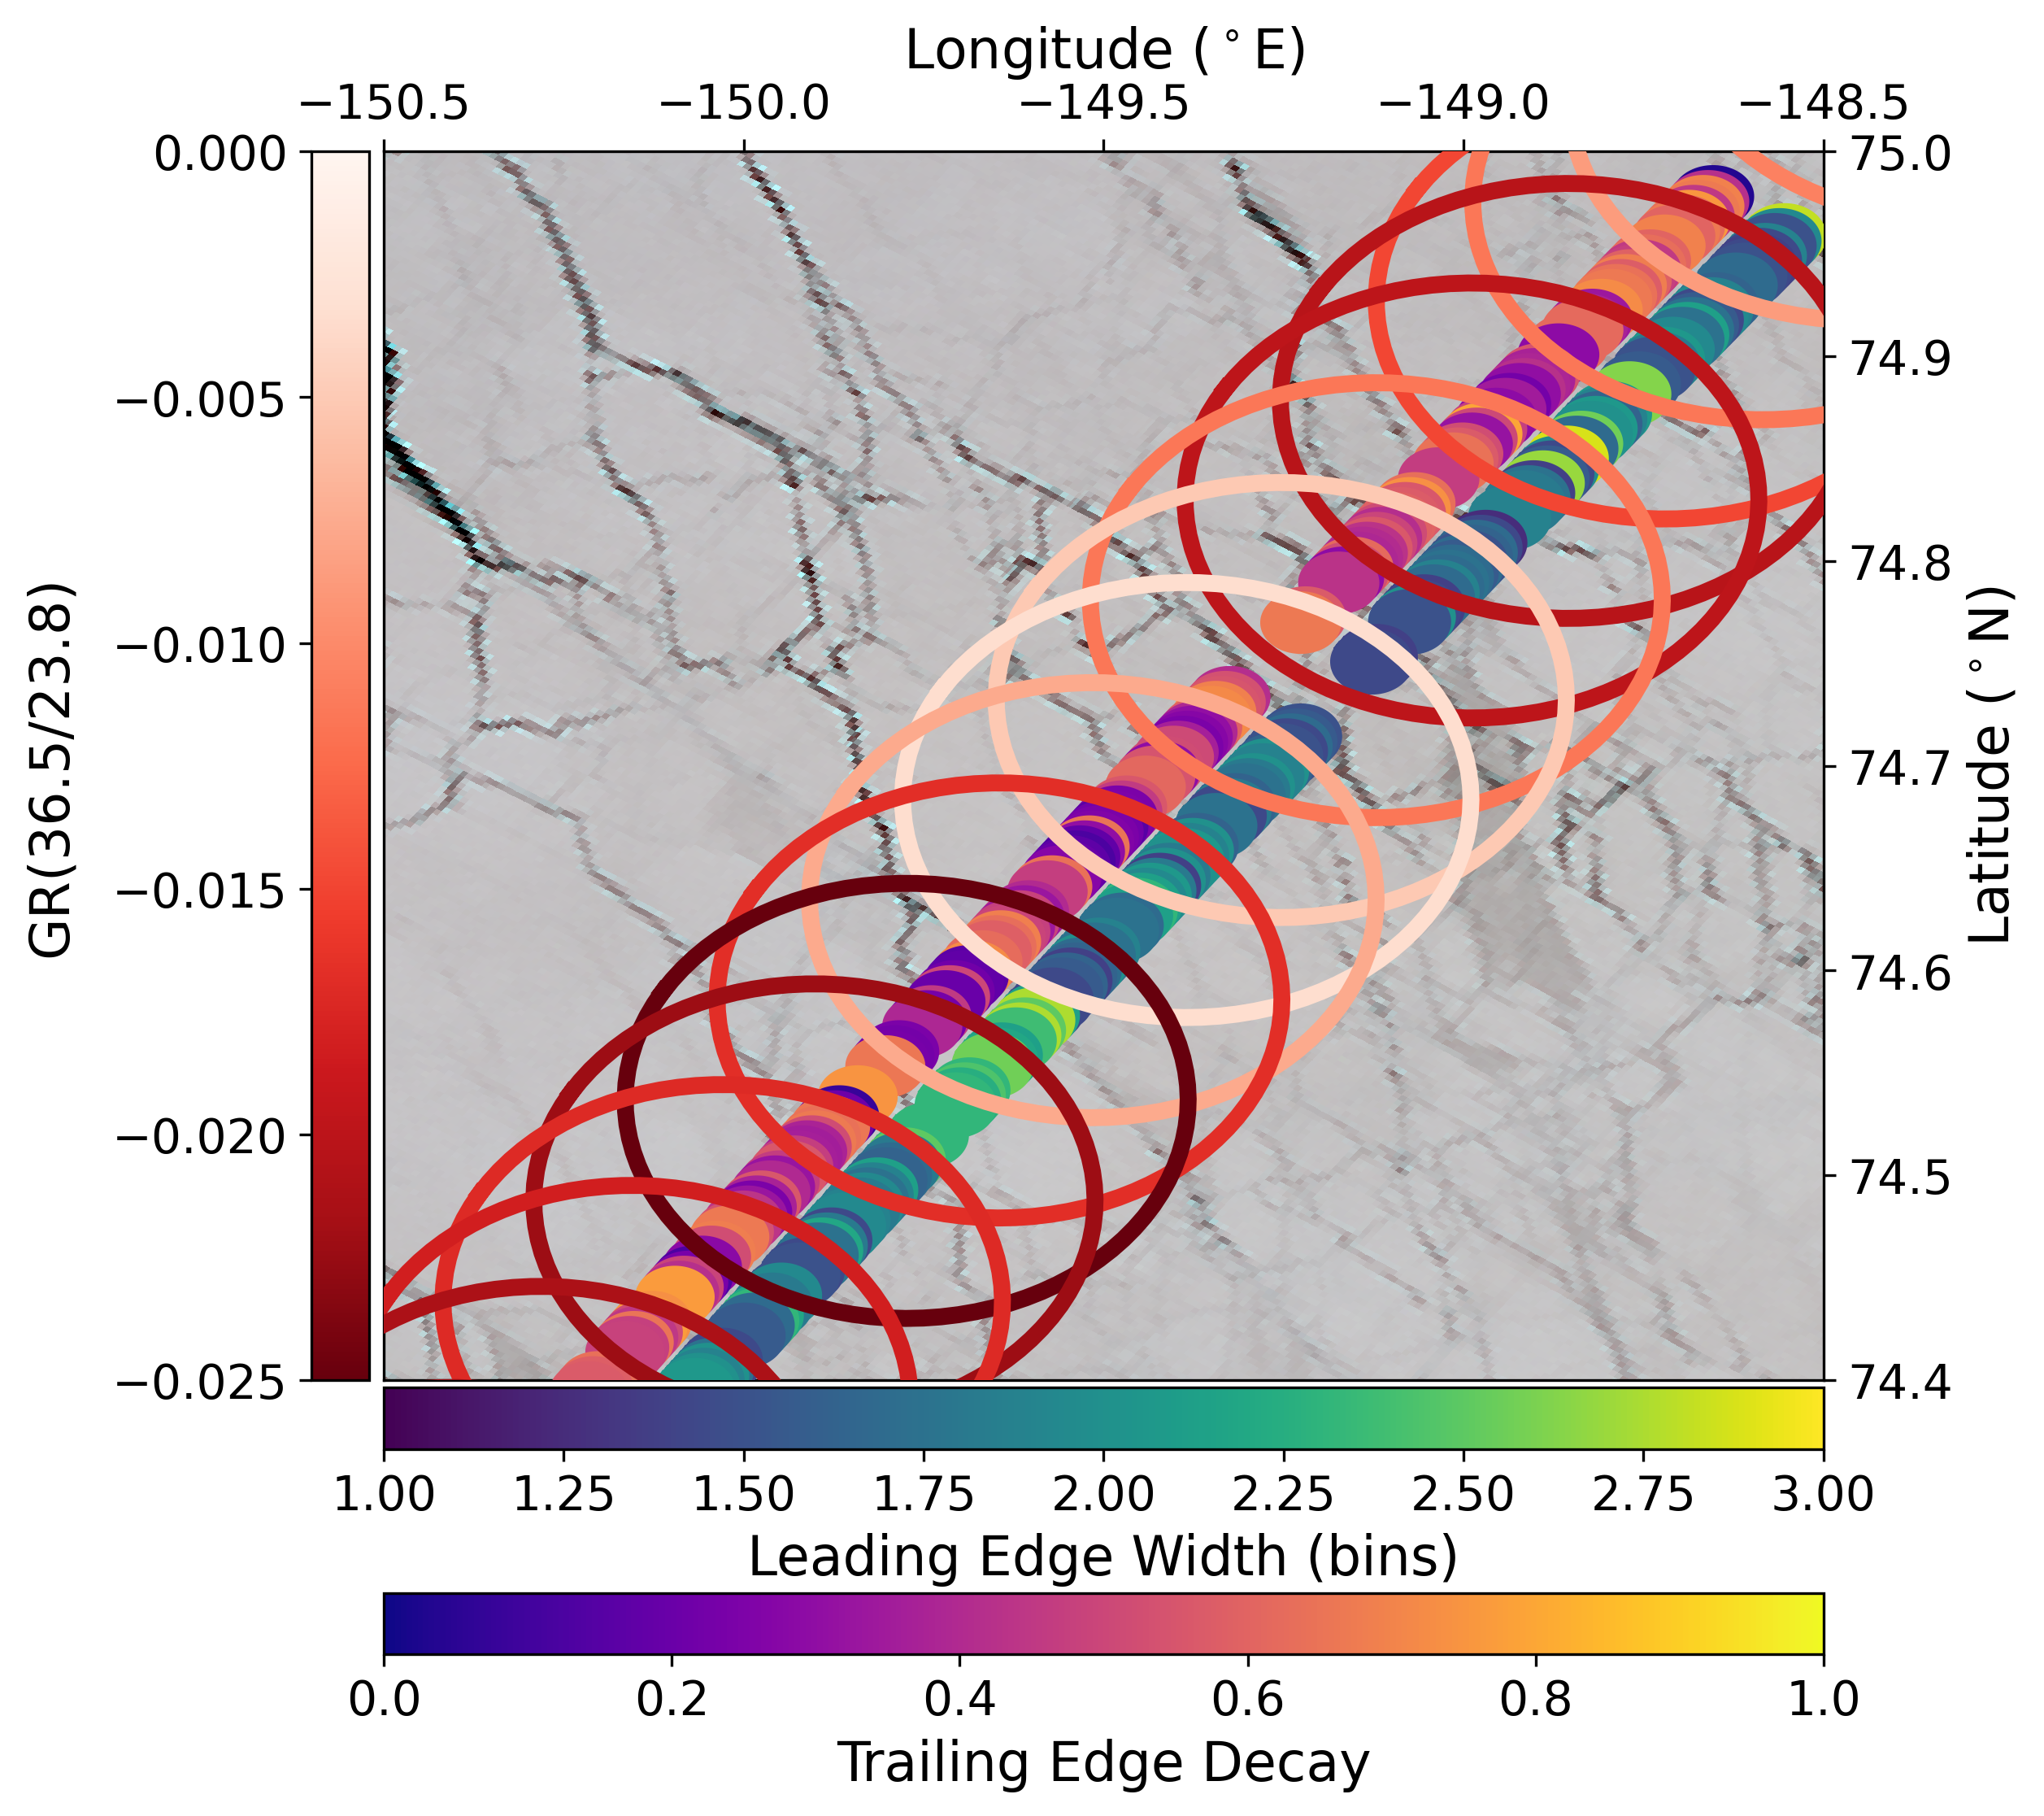

In [9]:
#define zoomed in bbox for plotting
zoomed_bbox = [-150.5, -148.5, 74.4, 75]

#create the figure
fig = plt.figure(figsize=(8, 8), dpi=300)
gs = gridspec.GridSpec(4, 2, height_ratios=[10, 0.5, 1.05, 0.5], width_ratios=[0.4, 10], hspace=0.02, wspace=0.02)

#main plot
ax = fig.add_subplot(gs[0, 1])
#plot the OLCI image
ax.pcolormesh(
    img_rgb['lons'], img_rgb['lats'],
    img_rgb, zorder=0
)
ax.set_xlim(zoomed_bbox[0], zoomed_bbox[1])
ax.set_ylim(zoomed_bbox[2], zoomed_bbox[3])
ax.set_xlabel(r'Longitude ($^\circ$E)', fontsize=16)
ax.set_ylabel(r'Latitude ($^\circ$N)', fontsize=16)
ax.yaxis.set_label_position("right")
ax.xaxis.set_label_position("top")
ax.yaxis.tick_right()
ax.xaxis.tick_top()
ax.tick_params(axis='both', labelsize=14)
ax.set_xticks(np.arange(zoomed_bbox[0], zoomed_bbox[1] + 0.5, 0.5))

#plot LEW polygons
for polygon, lew_color in zip(sral_lew_polygons, lew_colors):
    if polygon.exterior is not None:
        x, y = polygon.exterior.xy
        ax.plot(x, y, color=lew_color, zorder=10, linewidth=3)
        ax.fill(x, y, color=lew_color, zorder=10)

#plot TED polygons
for polygon, ted_color in zip(sral_ted_polygons, ted_colors):
    if polygon.exterior is not None:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=ted_color, zorder=15)

#plot GR polygons
for polygon, color in zip(mwr_polygons, s3_gr_colors):
    if polygon.exterior is not None:
        x, y = polygon.exterior.xy
        ax.plot(x, y, color=color, alpha=1, zorder=25, linewidth=5)

#colorbar for LEW (horizontal below the main plot)
cax_lew = fig.add_subplot(gs[1, 1])
cbar_lew = plt.colorbar(lew_sm, cax=cax_lew, orientation='horizontal')
cbar_lew.ax.tick_params(labelsize=14)
cbar_lew.set_label('Leading Edge Width (bins)', fontsize=16)

#colorbar for TED (horizontal below the LEW colorbar)
cax_ted = fig.add_subplot(gs[3, 1])
cbar_ted = plt.colorbar(ted_sm, cax=cax_ted, orientation='horizontal')
cbar_ted.ax.tick_params(labelsize=14)
cbar_ted.set_label('Trailing Edge Decay', fontsize=16)

#colorbar for GR (vertical on the left-hand side)
cax_gr = fig.add_subplot(gs[0, 0])
cbar_gr = plt.colorbar(gr_sm, cax=cax_gr, orientation='vertical')
cbar_gr.ax.tick_params(labelsize=14, labelleft=True, labelright=False, left=True, right=False) 
cbar_gr.set_label('GR(36.5/23.8)', fontsize=16, labelpad=10) 
cbar_gr.ax.yaxis.set_label_position('left')
cbar_gr.ax.yaxis.set_ticks_position('left')

#save and show
plt.savefig('S3_mwr_gr_and_sral_features_example.png', dpi=300, bbox_inches='tight')
plt.show()